In [1]:
%pip install lightgbm
%pip install pip -U scikit-learn
%pip install dvc

import json
from pathlib import Path


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Data Source: #

https://kaggle.com/adammaus/predicting-churn-for-bank-customers

# Description #

This dataset contains 10,000 records, each of which corresponds to a different bank's user. The target is to determine ExitedTask, a binary variable that describes whether the user decided to leave the bank. There are row and customer identifiers, four columns describing personal information about the user (surname, location, gender and age) and other columns containing information about the loan (credit score, current balance, active member, etc.)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier   
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, ConfusionMatrixDisplay


This notebook illustrates standard MLflow where we first set up some parameters, for both our model and how we load and preprocess our data. 

# SET UP PARAMETERS

In [3]:
churn_filepath = Path('data')/'Churn_Modelling.csv'
cat_cols = []
num_cols = [
    'CreditScore',
    'Age',
    'Tenure',
    'Balance',
    'NumOfProducts',
    'HasCrCard',
    'IsActiveMember',
    'EstimatedSalary',
]
targ_col='Exited'
test_size = .25
random_state = 42
models_dir = Path('models')
models_dir.mkdir(exist_ok=True)
model_fname = 'model.joblib'

#papermill parameter
model_type = 'random-forest'
n_estimators = 50
max_depth = 5

train_params = {'n_estimators':n_estimators,
                'max_depth': max_depth}

READ DATA

In [4]:
df= pd.read_csv('Churn_Modelling.csv')

In [5]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Data Exploration

In [6]:
df.shape

(10000, 14)

In [7]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [9]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Data Processing & Splitting

In [10]:
X,y = df[cat_cols + num_cols], df[targ_col] # splitting data set into features and targets


In [11]:
y.mean()

0.2037

In [12]:
# split into train and test 

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=test_size,
                                                    random_state=random_state)

Train the Model

In [13]:
# In training the model, here we want to have an option betweeen training a classifier using random forest versus LGBM versus light gbm
if model_type=='random-forest':
    clf = RandomForestClassifier(random_state=random_state,**train_params)
elif model_type=='lightgbm':
    clf = LGBMClassifier(random_state=random_state, **train_params)
else: 
    raise Exception('Unsupported model_type')
clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, n_estimators=50, random_state=42)

In [14]:
# once the file is trained you save it to a file 
dump(clf,models_dir/model_fname)

['models/model.joblib']

In [15]:
clf=load(models_dir/model_fname)

# Model Evaluation

In [16]:
# Now you want to produce some evaluation plots. The following is what Alex Kim had as his code but it did not work for me. 
# Produced the error that 'plot_confusion_matrix' is not defined so ended up defining and creating my own version.
#plot_confusion_matrix(clf, X_test, y_test, normalize='true',cmap=plt.cm.Blues)
#plt.savefig(Path('eval_plots')/cm.png)


Normalized confusion matrix
[[0.97903145 0.02096855]
 [0.61971831 0.38028169]]


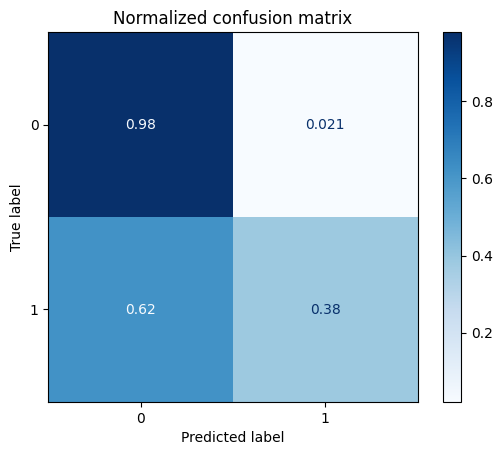

In [17]:
# Creating confusion matrix evaluation plot.

#predictions = clf.predict(X_test)
#cm = confusion_matrix(y_test, predictions, labels=clf.classes, normalize='true',cmap=plt.cm.Blues)
titles_options = [
    #("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)


plt.savefig(Path('eval_plots')/'cm.png')

In [18]:
y_prob = clf.predict_proba(X_test)
y_pred = y_prob[:,1]>= .5

In [19]:
import os
from dvclive import Live
live = Live('eval_plots')
live.log_sklearn_plot('roc', y_test, y_prob [:,1])


In [20]:
# here we are producing binary classification metrics  (the f1 score and the roc auc, which is equal to the area under receiving operator curve )
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test,y_prob[:,1])
metrics = {
    'f1': f1,
    'roc_auc': roc_auc
}
metrics


{'f1': 0.5192307692307692, 'roc_auc': 0.8356825928109848}

In [21]:
# save metrics into a json file
# 
json.dump(
    obj = metrics,
    fp = open('metrics.json','w'),
    indent = 4,
    sort_keys = True
)

Once you have your notebook defined, you can define your pipeline. This is a one stage pipeline that runs the notebook top to bottom with papermill. 

In [22]:
 
save_dvc_exp=True

In [ ]:
#from dvclive import Live

#with Live(save_dvc_exp=True) as live:
 #   live.log_param("epochs", NUM_EPOCHS)

  #  for epoch in range(NUM_EPOCHS):
   #     train_model(...)
    #    metrics = evaluate_model(...)
     #   for metric_name, value in metrics.items():
      #      live.log_metric(metric_name, value)
       # live.next_step()

In [ ]:
#huggingface
#trainer.add_callback(DVCLiveCallback(save_dvc_exp=True))
#trainer.train()